#***TASK 2***

#***Market Basket Analysis in Python using Apriori Algorithm***

In [1]:
#Import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [10]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx',  parse_dates=['InvoiceDate'])
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [12]:
df.shape

(541909, 8)

In [13]:
df.describe().round(2)

Quantity  UnitPrice  CustomerID
count  541909.00  541909.00   406829.00
mean        9.55       4.61    15287.69
std       218.08      96.76     1713.60
min    -80995.00  -11062.06    12346.00
25%         1.00       1.25    13953.00
50%         3.00       2.08    15152.00
75%        10.00       4.13    16791.00
max     80995.00   38970.00    18287.00

In [14]:
#Ensure that the data type in the InvoiceNo column is in the form of a string.
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df.sort_values('InvoiceNo', ascending=False)

InvoiceNo StockCode                          Description  Quantity  \
541717   C581569     20979        36 PENCILS TUBE RED RETROSPOT        -5   
541716   C581569     84978     HANGING HEART JAR T-LIGHT HOLDER        -1   
541715   C581568     21258           VICTORIAN SEWING BOX LARGE        -5   
541541   C581499         M                               Manual        -1   
540448   C581490     22178      VICTORIAN GLASS HANGING T-LIGHT       -12   
...          ...       ...                                  ...       ...   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
1         536365     71053                  WHITE METAL LANTERN         6   
5         536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6         536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   

               InvoiceDate  UnitPrice  CustomerID         Country  
541717 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
541716 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
541715 2011-12-09 11:57:00      10.95     15311.0  United Kingdom  
541541 2011-12-09 10:28:00     224.69     15498.0  United Kingdom  
540448 2011-12-09 09:57:00       1.95     14397.0  United Kingdom  
...                    ...        ...         ...             ...  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
5      2010-12-01 08:26:00       7.65     17850.0  United Kingdom  
6      2010-12-01 08:26:00       4.25     17850.0  United Kingdom  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  

[541909 rows x 8 columns]

In [15]:
#Delete canceled transaction rows
df = df[~df['InvoiceNo'].str.contains('C')]
df.shape

(532621, 8)

In [16]:
def missingvalue(data):
    missing_value = data.isnull().sum(axis = 0).reset_index()
    missing_value.columns = ['variable', 'number_of_missing']
    missing_value['percentage_of_missing'] = (missing_value['number_of_missing'])/data.shape[0]*100
    mv = missing_value.sort_values('percentage_of_missing', ascending = False).reset_index(drop=True)
    return mv
missingvalue(df)

variable  number_of_missing  percentage_of_missing
0   CustomerID             134697              25.289465
1  Description               1454               0.272990
2    InvoiceNo                  0               0.000000
3    StockCode                  0               0.000000
4     Quantity                  0               0.000000
5  InvoiceDate                  0               0.000000
6    UnitPrice                  0               0.000000
7      Country                  0               0.000000

In [17]:
df = df.dropna(subset = ['CustomerID', 'Description'])
missingvalue(df)

variable  number_of_missing  percentage_of_missing
0    InvoiceNo                  0                    0.0
1    StockCode                  0                    0.0
2  Description                  0                    0.0
3     Quantity                  0                    0.0
4  InvoiceDate                  0                    0.0
5    UnitPrice                  0                    0.0
6   CustomerID                  0                    0.0
7      Country                  0                    0.0

In [18]:
#Remove spaces at the beginning or end of sentences
df['Description'] = df['Description'].str.strip()
df.shape

(397924, 8)

In [19]:
df.info()
df['CustomerID'] = df['CustomerID'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [20]:
df.describe()

Quantity      UnitPrice     CustomerID
count  397924.000000  397924.000000  397924.000000
mean       13.021823       3.116174   15294.315171
std       180.420210      22.096788    1713.169877
min         1.000000       0.000000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000

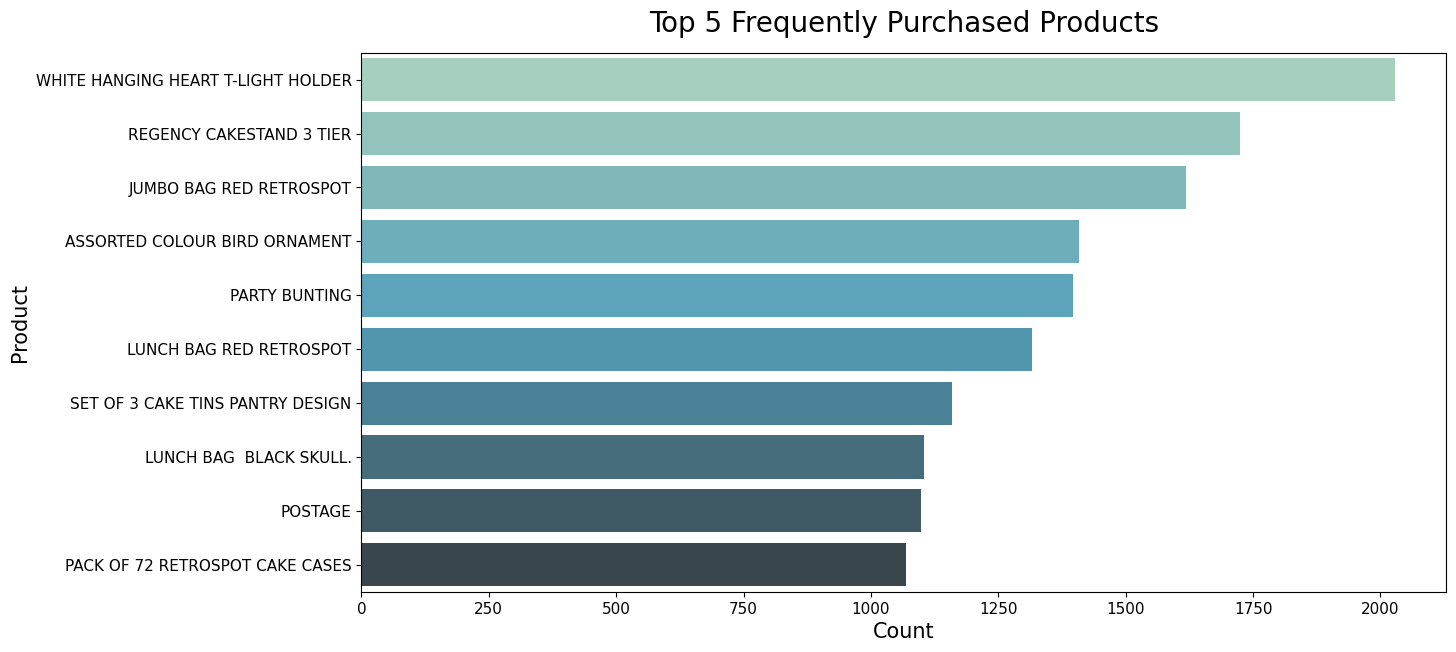

In [21]:
plt.figure(figsize = (14,7))
ax = sns.countplot(y = df['Description'],
                   order = df["Description"].value_counts().iloc[:10].index,
                   palette = "GnBu_d")
ax.set_title("Top 5 Frequently Purchased Products", size = 20, pad=15)
ax.set_xlabel("Count", size = 15)
ax.set_ylabel("Product", size = 15)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
plt.show()

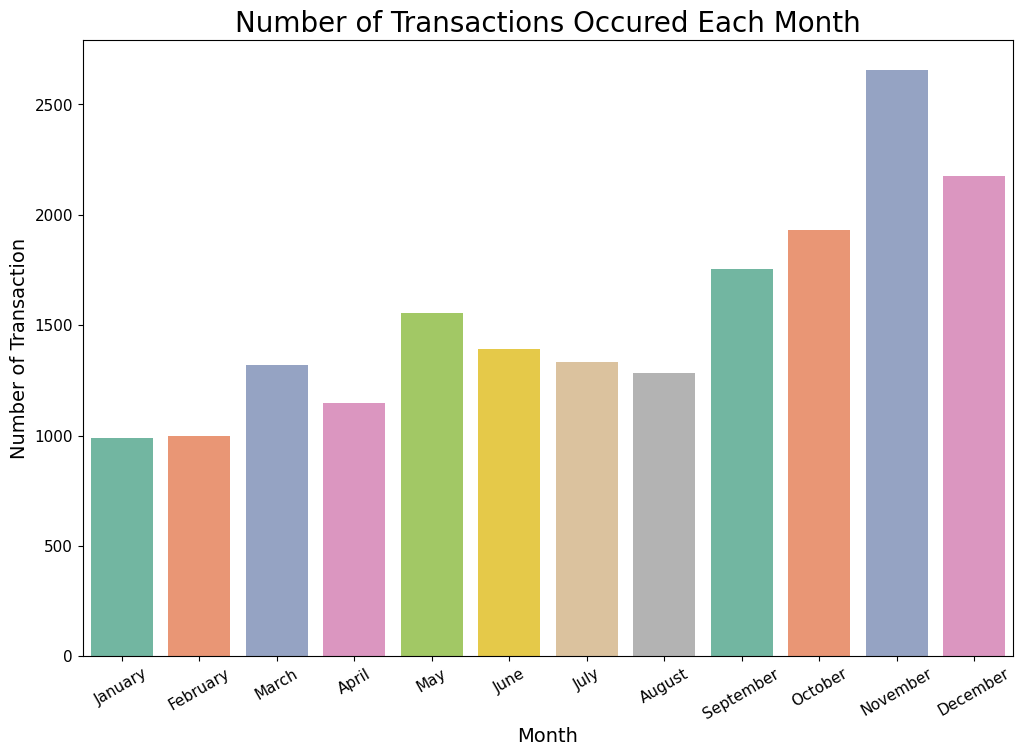

In [22]:
order_month = df.groupby(df['InvoiceDate'].dt.month)['InvoiceNo'].nunique()

plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'InvoiceDate', y = 'InvoiceNo', data = order_month.reset_index(), palette = "Set2")
ax.set_title('Number of Transactions Occured Each Month', size = 20)
ax.set_xlabel('Month', size = 14)
ax.set_ylabel('Number of Transaction', size = 14)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], rotation = 30)
plt.show()

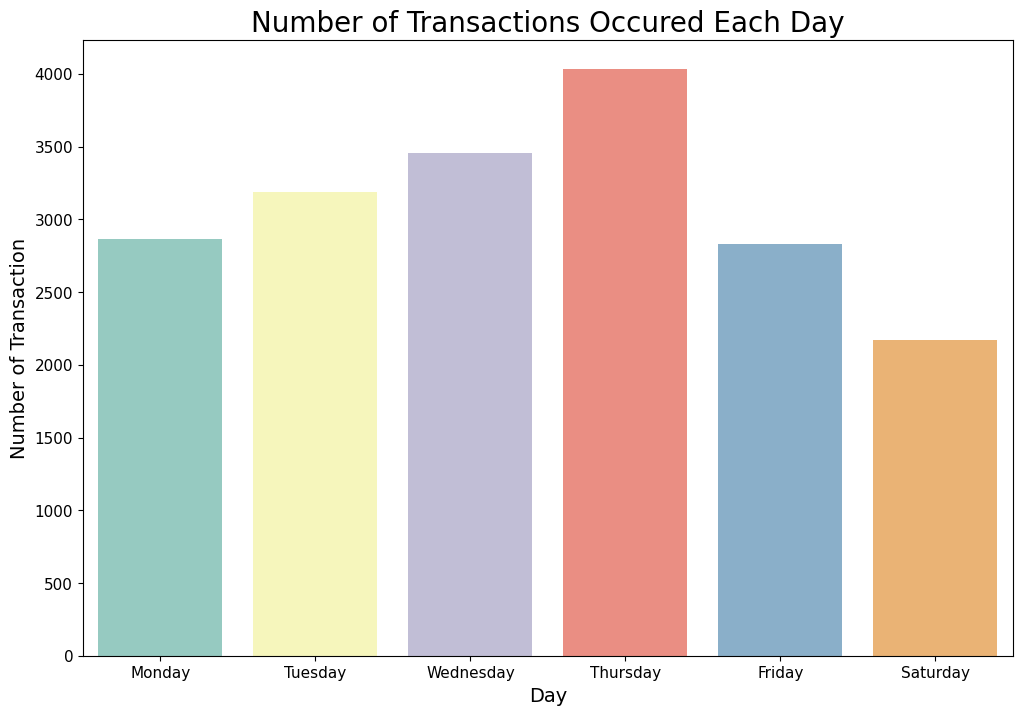

In [23]:
order_day = df.groupby(df['InvoiceDate'].dt.dayofweek)['InvoiceNo'].nunique()

plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'InvoiceDate', y = 'InvoiceNo', data = order_day.reset_index(), palette = "Set3")
ax.set_title('Number of Transactions Occured Each Day', size = 20)
ax.set_xlabel('Day', size = 14)
ax.set_ylabel('Number of Transaction', size = 14)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.show()

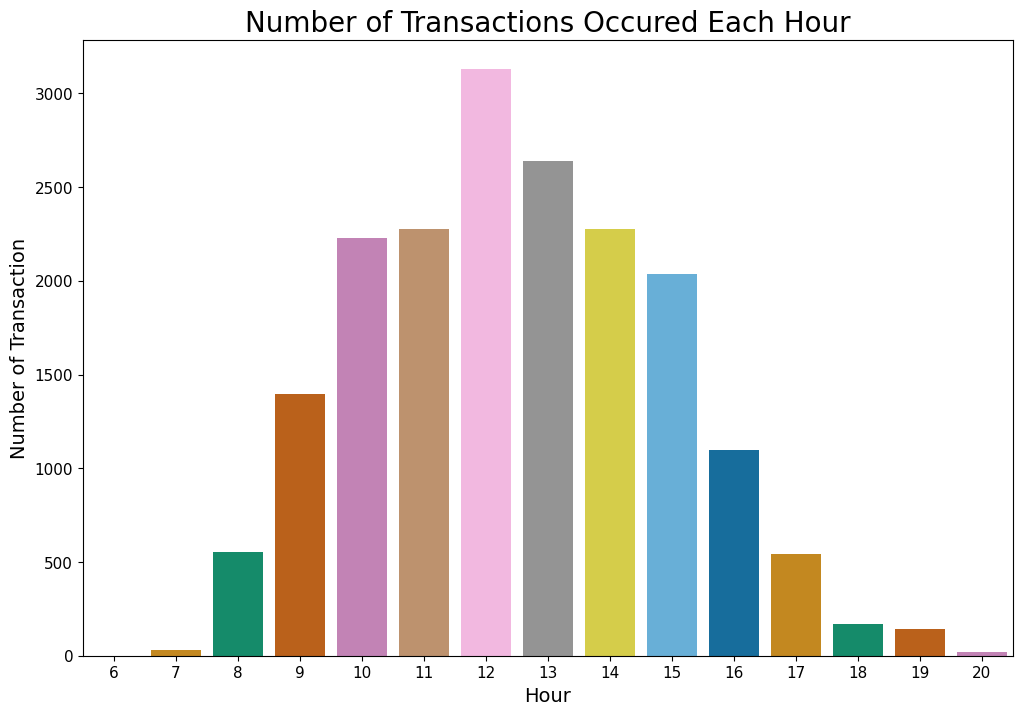

In [24]:
order_hour = df.groupby(df['InvoiceDate'].dt.hour)['InvoiceNo'].nunique()

plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'InvoiceDate', y = 'InvoiceNo', data = order_hour.reset_index(), palette = "colorblind")
ax.set_title('Number of Transactions Occured Each Hour', size = 20)
ax.set_xlabel('Hour', size = 14)
ax.set_ylabel('Number of Transaction', size = 14)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
plt.show()

In [25]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34

In [26]:
price_cust = pd.pivot_table(df, index='CustomerID', values='TotalPrice', aggfunc=np.sum)
print('The following are 5 customers who spend the most money on Online Retail:')
price_cust.sort_values('TotalPrice', ascending=False)[:5]

The following are 5 customers who spend the most money on Online Retail:


TotalPrice
CustomerID            
14646        280206.02
18102        259657.30
17450        194550.79
16446        168472.50
14911        143825.06

In [27]:
order_cust = pd.pivot_table(df, index='CustomerID', values='InvoiceNo', aggfunc=pd.Series.nunique)
print('The following are the 5 customers who most frequently shop at Online Retail:')
order_cust.sort_values('InvoiceNo', ascending=False)[:5]

The following are the 5 customers who most frequently shop at Online Retail:


InvoiceNo
CustomerID           
12748             210
14911             201
17841             124
13089              97
14606              93

In [28]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

  InvoiceMonth  
0   2010-12-01  
1   2010-12-01  
2   2010-12-01  
3   2010-12-01  
4   2010-12-01

In [29]:
group = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = group.transform('min')
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
541906    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
...                    ...        ...         ...             ...         ...   
541904 2011-12-09 12:50:00       0.85       12680          France       10.20   
541905 2011-12-09 12:50:00       2.10       12680          France       12.60   
541906 2011-12-09 12:50:00       4.15       12680          France       16.60   
541907 2011-12-09 12:50:00       4.15       12680          France       16.60   
541908 2011-12-09 12:50:00       4.95       12680          France       14.85   

       InvoiceMonth CohortMonth  
0        2010-12-01  2010-12-01  
1        2010-12-01  2010-12-01  
2        2010-12-01  2010-12-01  
3        2010-12-01  2010-12-01  
4        2010-12-01  2010-12-01  
...             ...         ...  
541904   2011-12-01  2011-08-01  
541905   2011-12-01  2011-08-01  
541906   2011-12-01  2011-08-01  
541907   2011-12-01  2011-08-01  
541908   2011-12-01  2011-08-01  

[397924 rows x 11 columns]

In [30]:
def date(data, column):
    year = data[column].dt.year
    month = data[column].dt.month
    day = data[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = date(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = date(df, 'CohortMonth')

In [31]:
diff_year = invoice_year - cohort_year
diff_month = invoice_month - cohort_month

In [32]:
df['IndexTime'] = diff_year*12 + diff_month + 1
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
541906    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
...                    ...        ...         ...             ...         ...   
541904 2011-12-09 12:50:00       0.85       12680          France       10.20   
541905 2011-12-09 12:50:00       2.10       12680          France       12.60   
541906 2011-12-09 12:50:00       4.15       12680          France       16.60   
541907 2011-12-09 12:50:00       4.15       12680          France       16.60   
541908 2011-12-09 12:50:00       4.95       12680          France       14.85   

       InvoiceMonth CohortMonth  IndexTime  
0        2010-12-01  2010-12-01          1  
1        2010-12-01  2010-12-01          1  
2        2010-12-01  2010-12-01          1  
3        2010-12-01  2010-12-01          1  
4        2010-12-01  2010-12-01          1  
...             ...         ...        ...  
541904   2011-12-01  2011-08-01          5  
541905   2011-12-01  2011-08-01          5  
541906   2011-12-01  2011-08-01          5  
541907   2011-12-01  2011-08-01          5  
541908   2011-12-01  2011-08-01          5  

[397924 rows x 12 columns]

In [33]:
count_cohort_time = df.groupby(['CohortMonth', 'IndexTime'])['CustomerID'].apply(pd.Series.nunique)
count_cohort_time = count_cohort_time.reset_index()
cohort_time_table = count_cohort_time.pivot(index='CohortMonth', columns='IndexTime', values='CustomerID')
cohort_time_table

IndexTime       1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0  313.0   
2011-01-01   417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0  125.0   
2011-02-01   380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   94.0   
2011-03-01   452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0  126.0   
2011-04-01   300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   22.0   
2011-05-01   284.0   54.0   49.0   49.0   59.0   66.0   75.0   27.0    NaN   
2011-06-01   242.0   42.0   38.0   64.0   56.0   81.0   23.0    NaN    NaN   
2011-07-01   188.0   34.0   39.0   42.0   51.0   21.0    NaN    NaN    NaN   
2011-08-01   169.0   35.0   42.0   41.0   21.0    NaN    NaN    NaN    NaN   
2011-09-01   299.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   358.0   86.0   41.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   324.0   36.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01    41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

IndexTime       10     11     12     13  
CohortMonth                              
2010-12-01   350.0  331.0  445.0  235.0  
2011-01-01   136.0  152.0   49.0    NaN  
2011-02-01   116.0   26.0    NaN    NaN  
2011-03-01    39.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  
2011-05-01     NaN    NaN    NaN    NaN  
2011-06-01     NaN    NaN    NaN    NaN  
2011-07-01     NaN    NaN    NaN    NaN  
2011-08-01     NaN    NaN    NaN    NaN  
2011-09-01     NaN    NaN    NaN    NaN  
2011-10-01     NaN    NaN    NaN    NaN  
2011-11-01     NaN    NaN    NaN    NaN  
2011-12-01     NaN    NaN    NaN    NaN

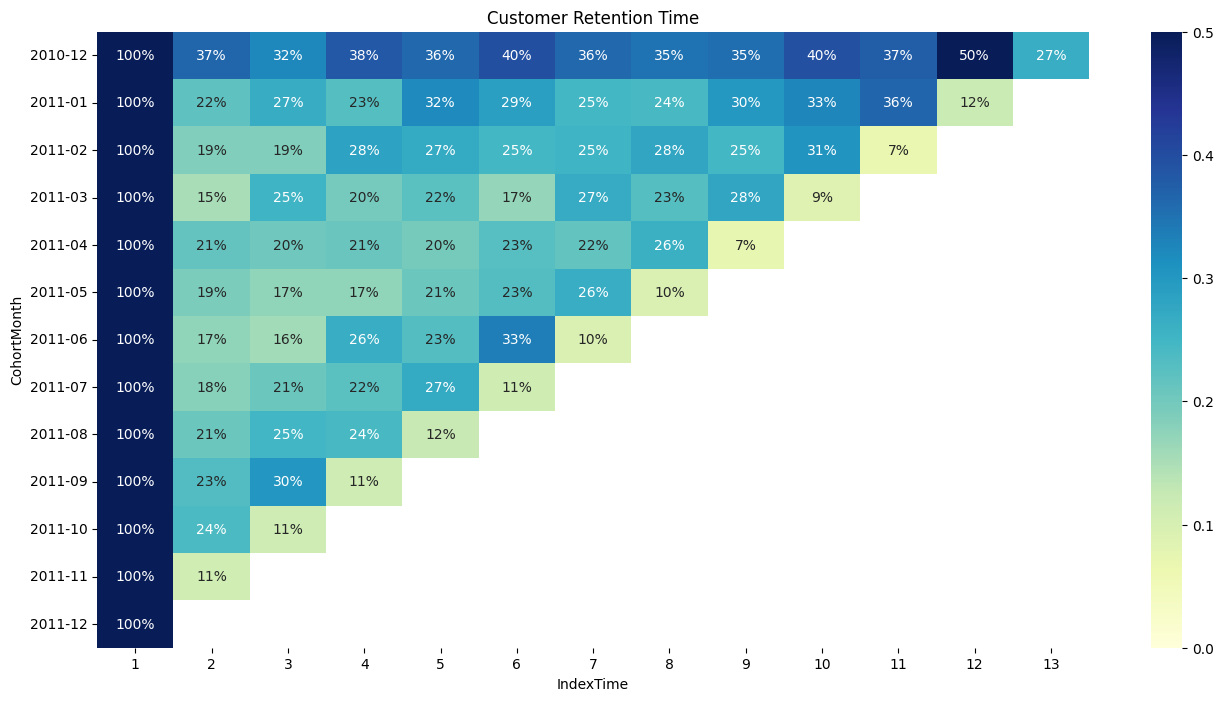

In [34]:
cohort_size = cohort_time_table.iloc[:,0]
#Divide all values in the cohort_time_table by cohort_size
retention = cohort_time_table.divide(cohort_size, axis = 0)
retention.index = retention.index.strftime('%Y-%m')
plt.figure(figsize= (16,8))
ax = sns.heatmap(data = retention, annot = True, annot_kws={"size":10}, vmin = 0.0, vmax = 0.5, fmt = '.0%', cmap = 'YlGnBu')
plt.title('Customer Retention Time')
plt.show()

In [35]:
print('Min: {}\nMax: {}'.format(min(df['InvoiceDate']), max(df['InvoiceDate'])))

Min: 2010-12-01 08:26:00
Max: 2011-12-09 12:50:00


In [36]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

  InvoiceMonth CohortMonth  IndexTime  
0   2010-12-01  2010-12-01          1  
1   2010-12-01  2010-12-01          1  
2   2010-12-01  2010-12-01          1  
3   2010-12-01  2010-12-01          1  
4   2010-12-01  2010-12-01          1

In [37]:
analysis_date = max(df['InvoiceDate']) + dt.timedelta(days= 1)
print((analysis_date).date())

2011-12-10


In [38]:
rfm_cust = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'})
rfm_cust.rename(columns= {'InvoiceDate':'Recency',
                         'InvoiceNo':'Frequency',
                         'TotalPrice':'Monetary'}, inplace = True)
rfm_cust

Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2        182   4310.00
12348            75         31   1797.24
12349            19         73   1757.55
12350           310         17    334.40
...             ...        ...       ...
18280           278         10    180.60
18281           181          7     80.82
18282             8         12    178.05
18283             4        756   2094.88
18287            43         70   1837.28

[4339 rows x 3 columns]

In [39]:
#1 is the best and 4 is the worst
r_labels = range(1,5) #The longer the customer last purchase, the worse it is
f_labels = range(4,0,-1) #The more purchases the customer makes, the better it is
m_labels = range(4,0,-1) #The more money the customer spends, the better it is

r_quartiles = pd.qcut(rfm_cust['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm_cust['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm_cust['Monetary'], q=4, labels=m_labels)

rfm_cust = rfm_cust.assign(R = r_quartiles.values, F = f_quartiles.values, M = m_quartiles.values)

rfm_cust

Recency  Frequency  Monetary  R  F  M
CustomerID                                       
12346           326          1  77183.60  4  4  1
12347             2        182   4310.00  1  1  1
12348            75         31   1797.24  3  3  1
12349            19         73   1757.55  2  2  1
12350           310         17    334.40  4  4  3
...             ...        ...       ... .. .. ..
18280           278         10    180.60  4  4  4
18281           181          7     80.82  4  4  4
18282             8         12    178.05  1  4  4
18283             4        756   2094.88  1  1  1
18287            43         70   1837.28  2  2  1

[4339 rows x 6 columns]

In [40]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])
rfm_cust['RFM_Segment'] = rfm_cust.apply(join_rfm, axis=1)
rfm_cust['RFM_Score'] = rfm_cust[['R', 'F', 'M']].sum(axis=1)
rfm_cust.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
CustomerID                                                              
12346           326          1  77183.60  4  4  1   4.04.01.0          9
12347             2        182   4310.00  1  1  1   1.01.01.0          3
12348            75         31   1797.24  3  3  1   3.03.01.0          7
12349            19         73   1757.55  2  2  1   2.02.01.0          5
12350           310         17    334.40  4  4  3   4.04.03.0         11

In [41]:
rfm_cust.groupby('RFM_Segment').size().sort_values(ascending=False)

RFM_Segment
1.01.01.0    447
4.04.04.0    384
2.01.01.0    217
4.03.03.0    206
3.04.04.0    179
            ... 
2.04.01.0      7
1.04.01.0      6
4.03.01.0      5
4.01.03.0      4
1.01.04.0      3
Length: 61, dtype: int64

In [42]:
rfm_cust.groupby('RFM_Score').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3             7.3     374.5   9319.2   447
4            21.1     187.7   4083.2   392
5            32.1     112.3   2049.4   426
6            46.0      80.0   1801.4   417
7            64.6      56.8    994.1   454
8            79.1      38.5    755.5   459
9            96.3      27.9    824.0   461
10          154.3      21.4    368.5   516
11          175.7      13.6    239.6   383
12          260.8       8.2    158.9   384

In [43]:
loyalty_level =['Platinum','Gold','Silver','Bronze']
loyalty_quartile = pd.qcut(rfm_cust['RFM_Score'], q=4, labels=loyalty_level)
rfm_cust['Loyalty_Level'] = loyalty_quartile.values
rfm_cust

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
CustomerID                                                                 
12346           326          1  77183.60  4  4  1   4.04.01.0          9   
12347             2        182   4310.00  1  1  1   1.01.01.0          3   
12348            75         31   1797.24  3  3  1   3.03.01.0          7   
12349            19         73   1757.55  2  2  1   2.02.01.0          5   
12350           310         17    334.40  4  4  3   4.04.03.0         11   
...             ...        ...       ... .. .. ..         ...        ...   
18280           278         10    180.60  4  4  4   4.04.04.0         12   
18281           181          7     80.82  4  4  4   4.04.04.0         12   
18282             8         12    178.05  1  4  4   1.04.04.0          9   
18283             4        756   2094.88  1  1  1   1.01.01.0          3   
18287            43         70   1837.28  2  2  1   2.02.01.0          5   

           Loyalty_Level  
CustomerID                
12346             Silver  
12347           Platinum  
12348               Gold  
12349           Platinum  
12350             Bronze  
...                  ...  
18280             Bronze  
18281             Bronze  
18282             Silver  
18283           Platinum  
18287           Platinum  

[4339 rows x 9 columns]

In [44]:
rfm_cust.groupby('Loyalty_Level').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
                 mean      mean     mean count
Loyalty_Level                                 
Platinum         19.9     228.3   5248.5  1265
Gold             63.8      57.8   1164.9  1330
Silver          127.0      24.5    583.4   977
Bronze          218.3      10.9    199.2   767

<ipython-input-45-aa6724072f56>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_cust[column], color = 'tomato', kde_kws={"color": "k"})


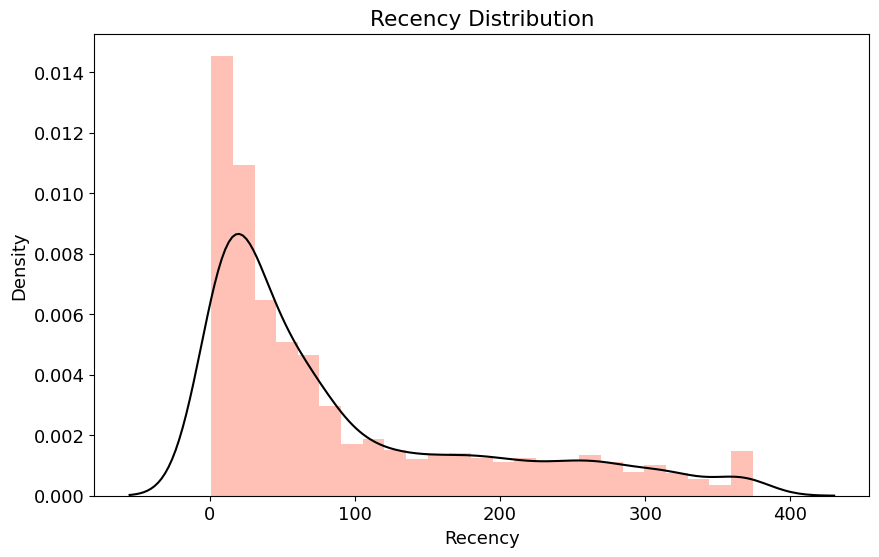

Skewness value of data Recency: 1.2463568823921842


In [45]:
def rfm_dist(column):
    r_skew = rfm_cust[column].skew()

    plt.rcParams['font.size']=13
    plt.figure(figsize=(10,6))
    sns.distplot(rfm_cust[column], color = 'tomato', kde_kws={"color": "k"})
    plt.title('{} Distribution'.format(column))

    plt.show()
    print('Skewness value of data {}: {}'.format(column, r_skew))
rfm_dist('Recency')

<ipython-input-45-aa6724072f56>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_cust[column], color = 'tomato', kde_kws={"color": "k"})


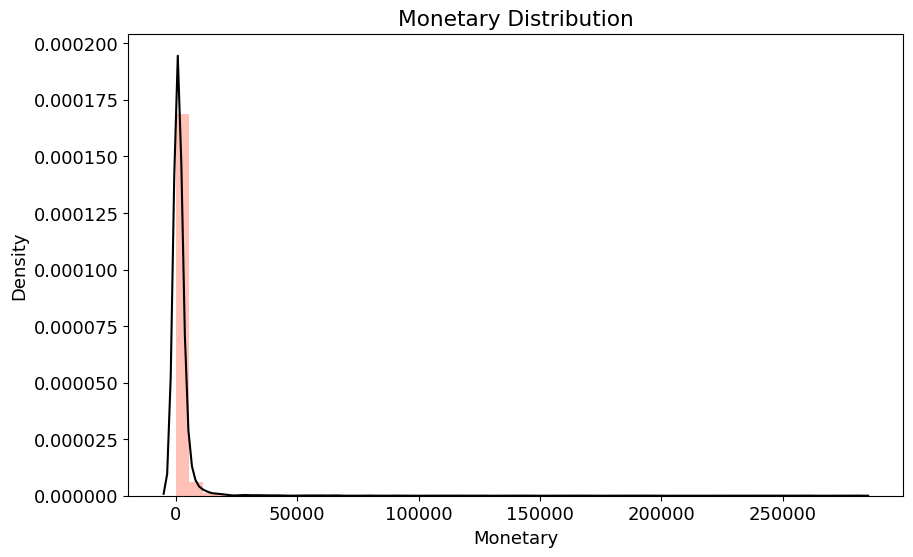

Skewness value of data Monetary: 19.326985305561823


In [46]:
rfm_dist('Monetary')

<ipython-input-45-aa6724072f56>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_cust[column], color = 'tomato', kde_kws={"color": "k"})


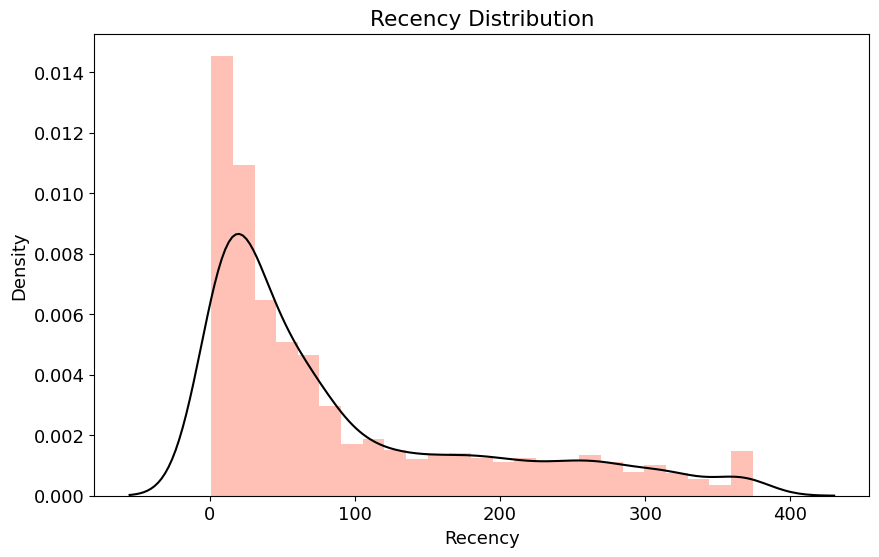

Skewness value of data Recency: 1.2463568823921842


In [47]:
rfm_dist('Recency')

In [48]:
print("The following is the skewness value for Recency, Frequency, and Monetary data:",
      '\nRecency   : {}'.format(rfm_cust['Recency'].skew()),
      '\nFrequency : {}'.format(rfm_cust['Frequency'].skew()),
      '\nMonetary  : {}'.format(rfm_cust['Monetary'].skew()))

The following is the skewness value for Recency, Frequency, and Monetary data: 
Recency   : 1.2463568823921842 
Frequency : 18.106242903118684 
Monetary  : 19.326985305561823


In [49]:
rfm_norm = rfm_cust[['Recency','Frequency','Monetary']]
rfm_norm.describe()

Recency    Frequency       Monetary
count  4339.000000  4339.000000    4339.000000
mean     92.518322    91.708689    2053.793018
std     100.009747   228.792852    8988.248381
min       1.000000     1.000000       0.000000
25%      18.000000    17.000000     307.245000
50%      51.000000    41.000000     674.450000
75%     142.000000   100.000000    1661.640000
max     374.000000  7847.000000  280206.020000

In [50]:
power = PowerTransformer().fit(rfm_norm)
rfm_transform =power.transform(rfm_norm)

#Standard Scaler to Scale the data
scaler = StandardScaler().fit(rfm_transform)
rfm_transform = scaler.transform(rfm_transform)

rfm_transform =pd.DataFrame(rfm_transform, index=rfm_norm.index, columns=rfm_norm.columns)
print('These are the mean value after data transformation:')
rfm_transform.describe()

These are the mean value after data transformation:


Recency     Frequency      Monetary
count  4.339000e+03  4.339000e+03  4.339000e+03
mean  -2.947631e-17  1.391937e-17 -1.965087e-17
std    1.000115e+00  1.000115e+00  1.000115e+00
min   -2.023615e+00 -2.420116e+00 -6.771115e+00
25%   -7.262454e-01 -6.778752e-01 -6.640781e-01
50%   -7.919785e-04 -1.754355e-03 -1.423703e-02
75%    8.380272e-01  7.009493e-01  6.862765e-01
max    1.755177e+00  4.225204e+00  3.885827e+00

<ipython-input-51-355d6857d7ab>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_transform[column], color = 'g', kde_kws={"color": "k"})


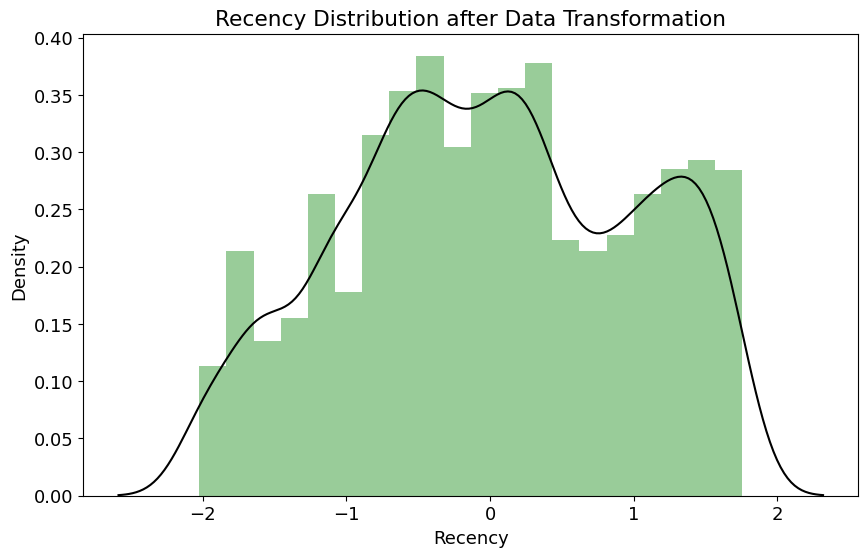

Skewness value of data Recency after data transformation: -0.05649210191594949


In [51]:
def rfm_dist_transform(column):
    r_skew_transform = rfm_transform[column].skew()

    plt.rcParams['font.size']=13
    plt.figure(figsize=(10,6))
    sns.distplot(rfm_transform[column], color = 'g', kde_kws={"color": "k"})
    plt.title('{} Distribution after Data Transformation'.format(column))

    plt.show()
    print('Skewness value of data {} after data transformation: {}'.format(column, r_skew_transform))
rfm_dist_transform('Recency')

<ipython-input-51-355d6857d7ab>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_transform[column], color = 'g', kde_kws={"color": "k"})


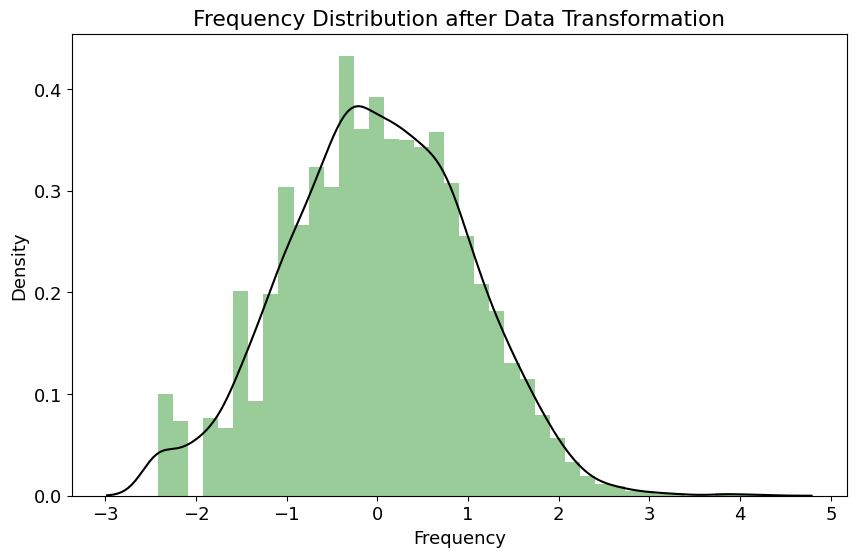

Skewness value of data Frequency after data transformation: -0.00010277002306379692


In [52]:
rfm_dist_transform('Frequency')

<ipython-input-51-355d6857d7ab>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_transform[column], color = 'g', kde_kws={"color": "k"})


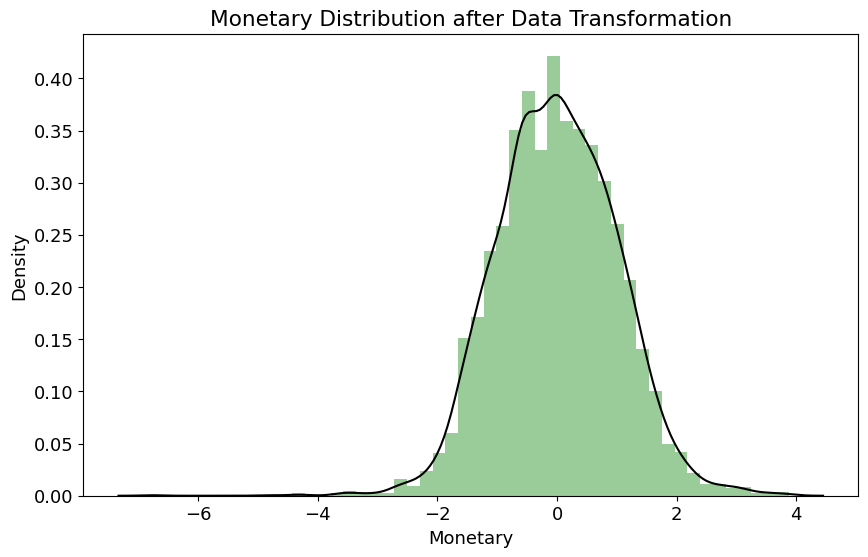

Skewness value of data Monetary after data transformation: -0.022753337015751482


In [53]:
rfm_dist_transform('Monetary')

In [54]:
print("The following is the skewness value for Recency, Frequency, and Monetary data after data transformation:",
      '\nRecency   : {}'.format(rfm_transform['Recency'].skew()),
      '\nFrequency : {}'.format(rfm_transform['Frequency'].skew()),
      '\nMonetary  : {}'.format(rfm_transform['Monetary'].skew()))

The following is the skewness value for Recency, Frequency, and Monetary data after data transformation: 
Recency   : -0.05649210191594949 
Frequency : -0.00010277002306379692 
Monetary  : -0.022753337015751482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

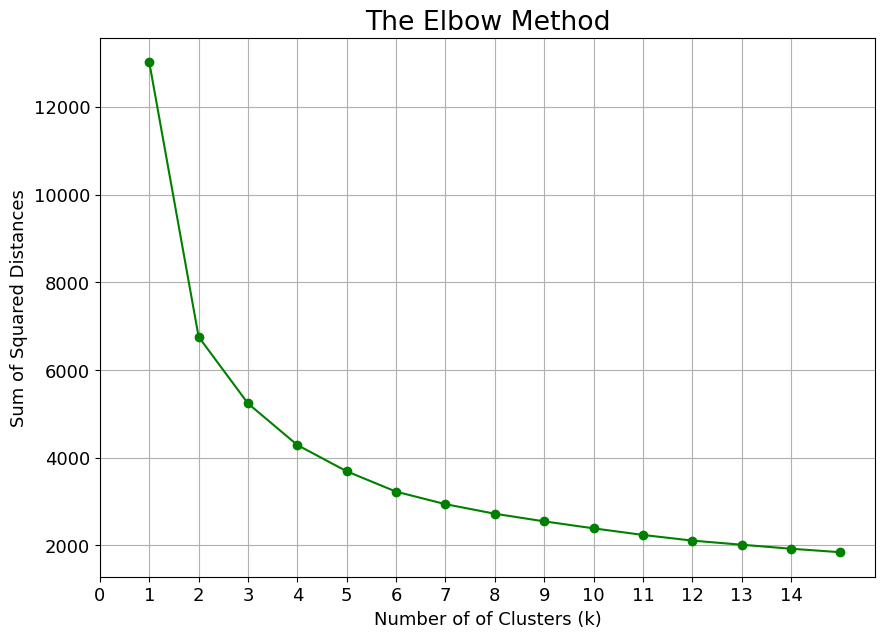

In [55]:
#Elbow Method
inertia=[]
cl = 15

for i in range(1,cl+1):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    kmeans.fit(rfm_transform)
    inertia.append(kmeans.inertia_) #sum of squared distances to closest cluster center


fig,ax = plt.subplots()
fig.set_size_inches(10, 7)
plt.rcParams['font.size']=16
plt.plot(range(1,cl+1), inertia, 'o-', color = 'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.title('The Elbow Method')
plt.xlabel('Number of of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.396689892885645


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.29935070361583976


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.30417720917225627


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.27881749014909174


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.277274890389003


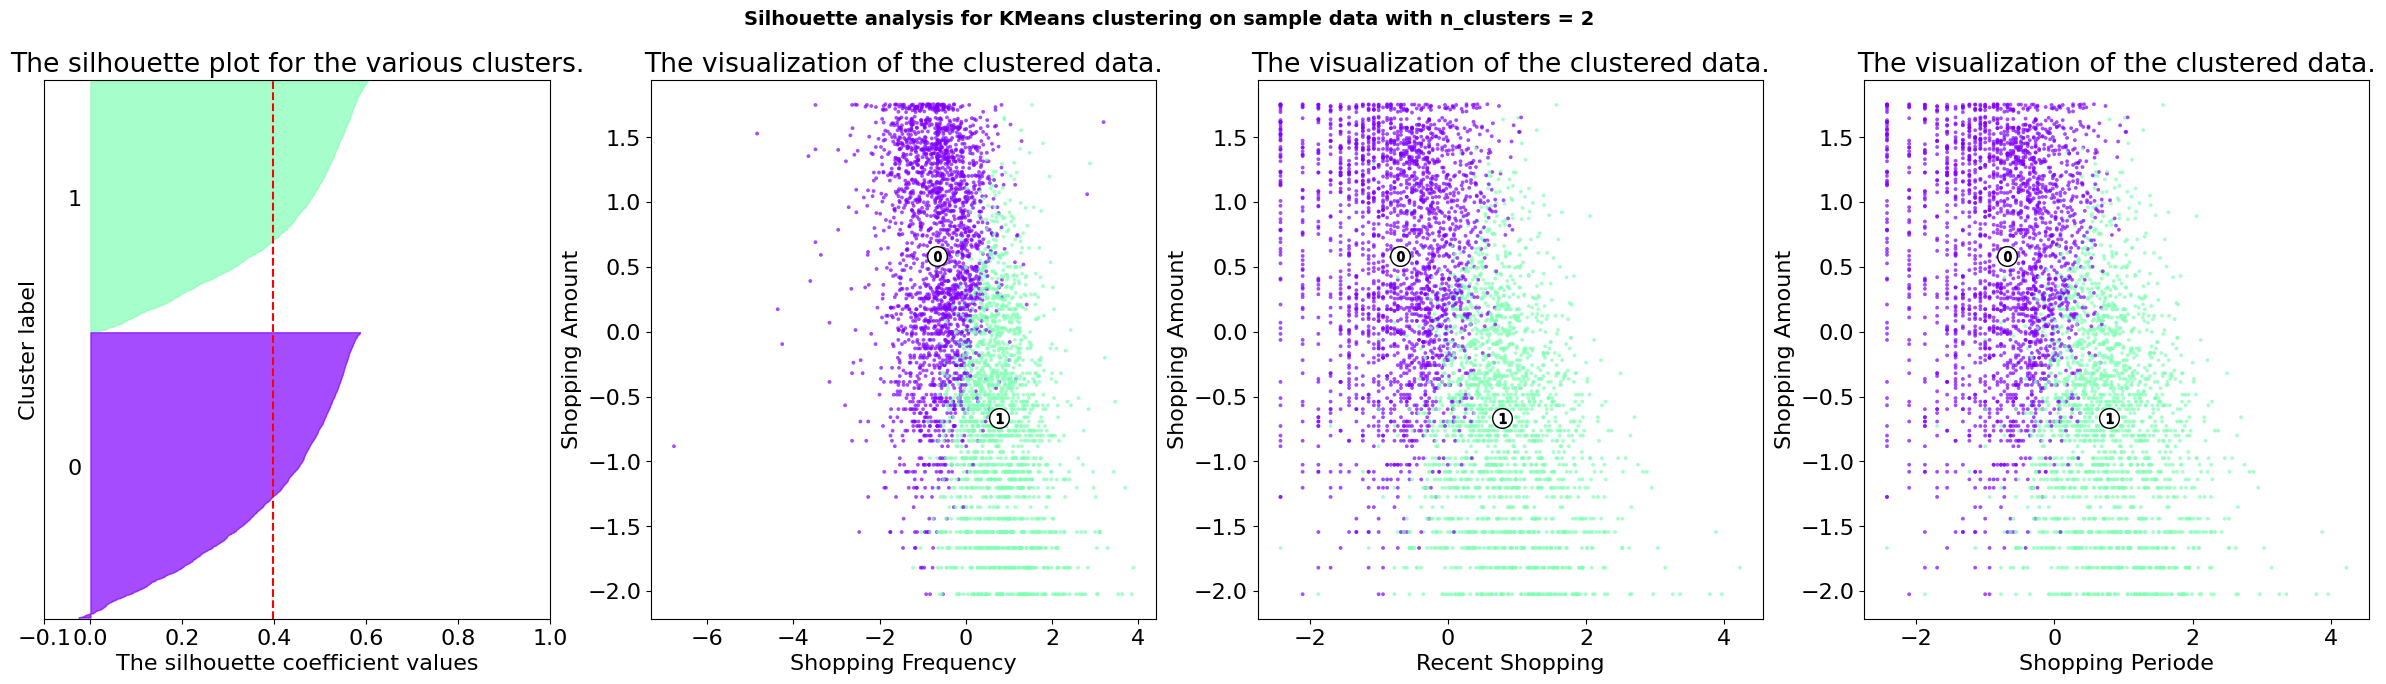

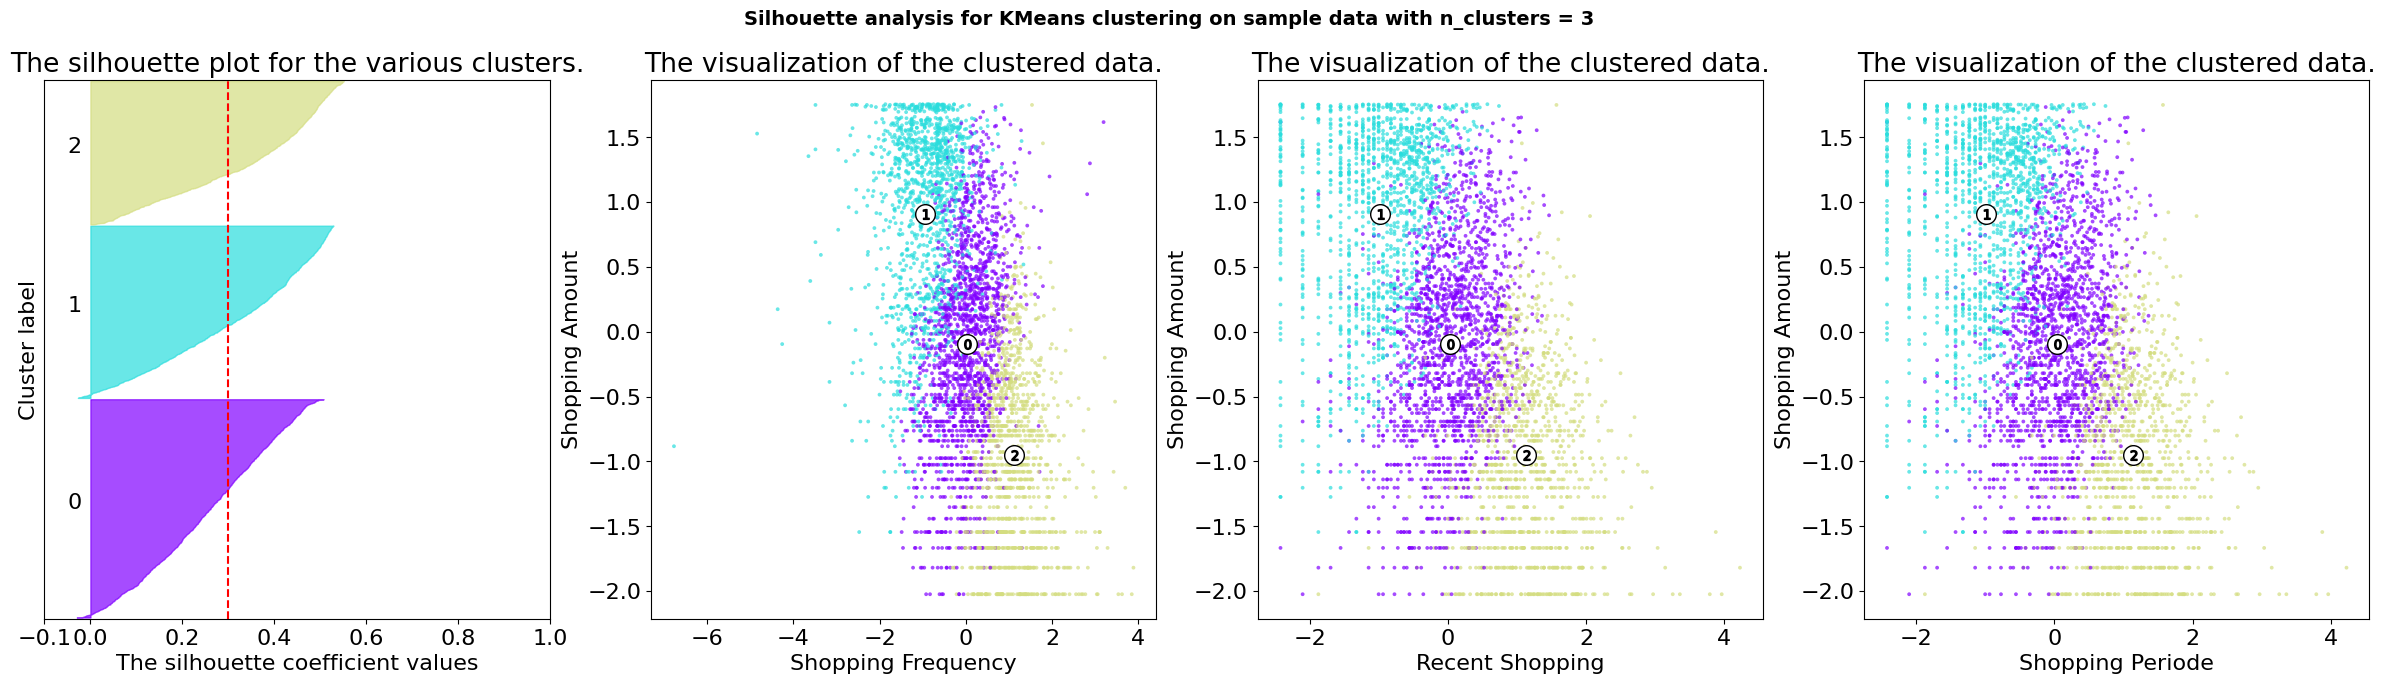

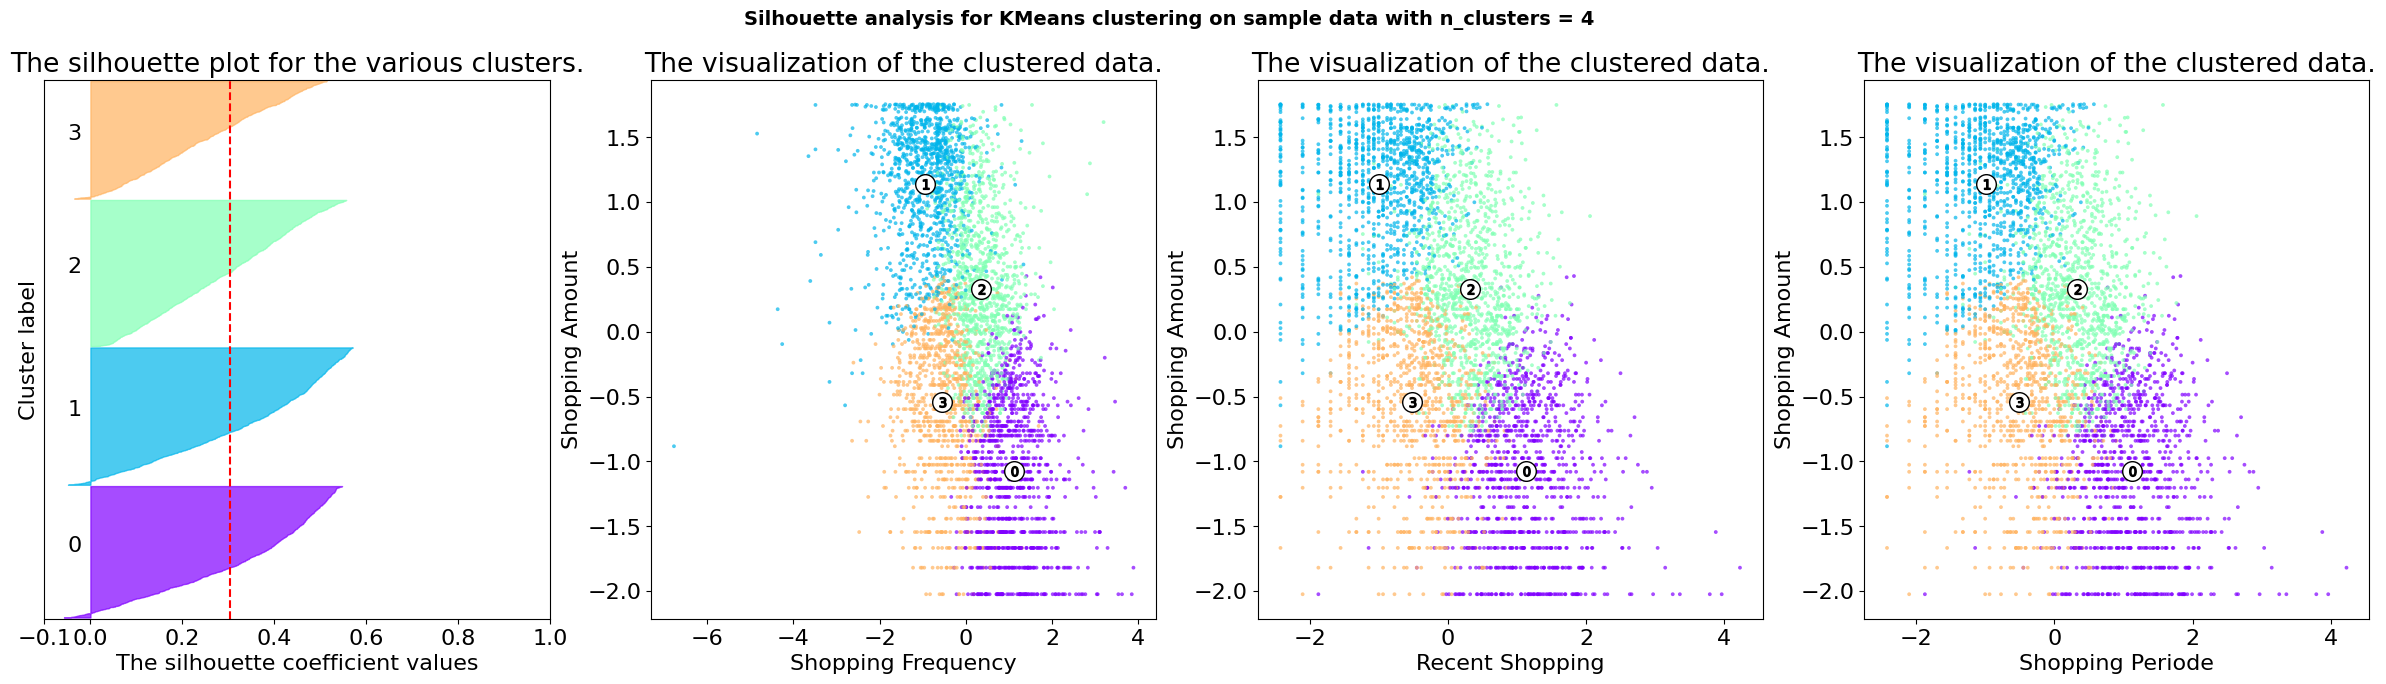

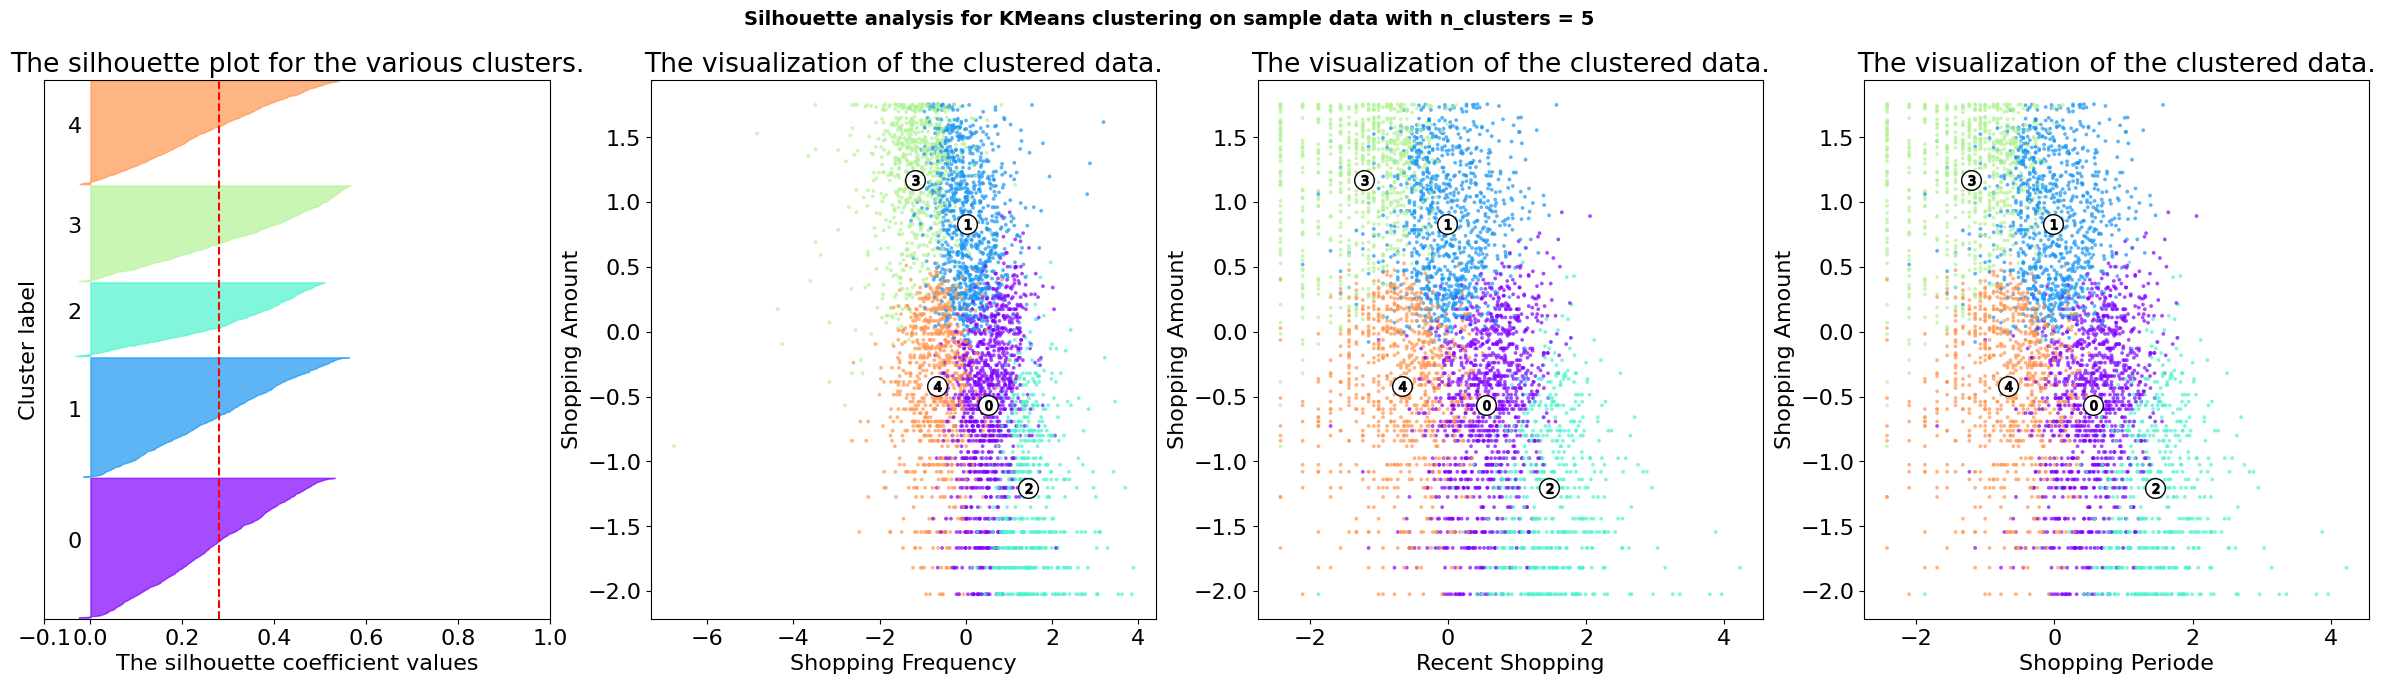

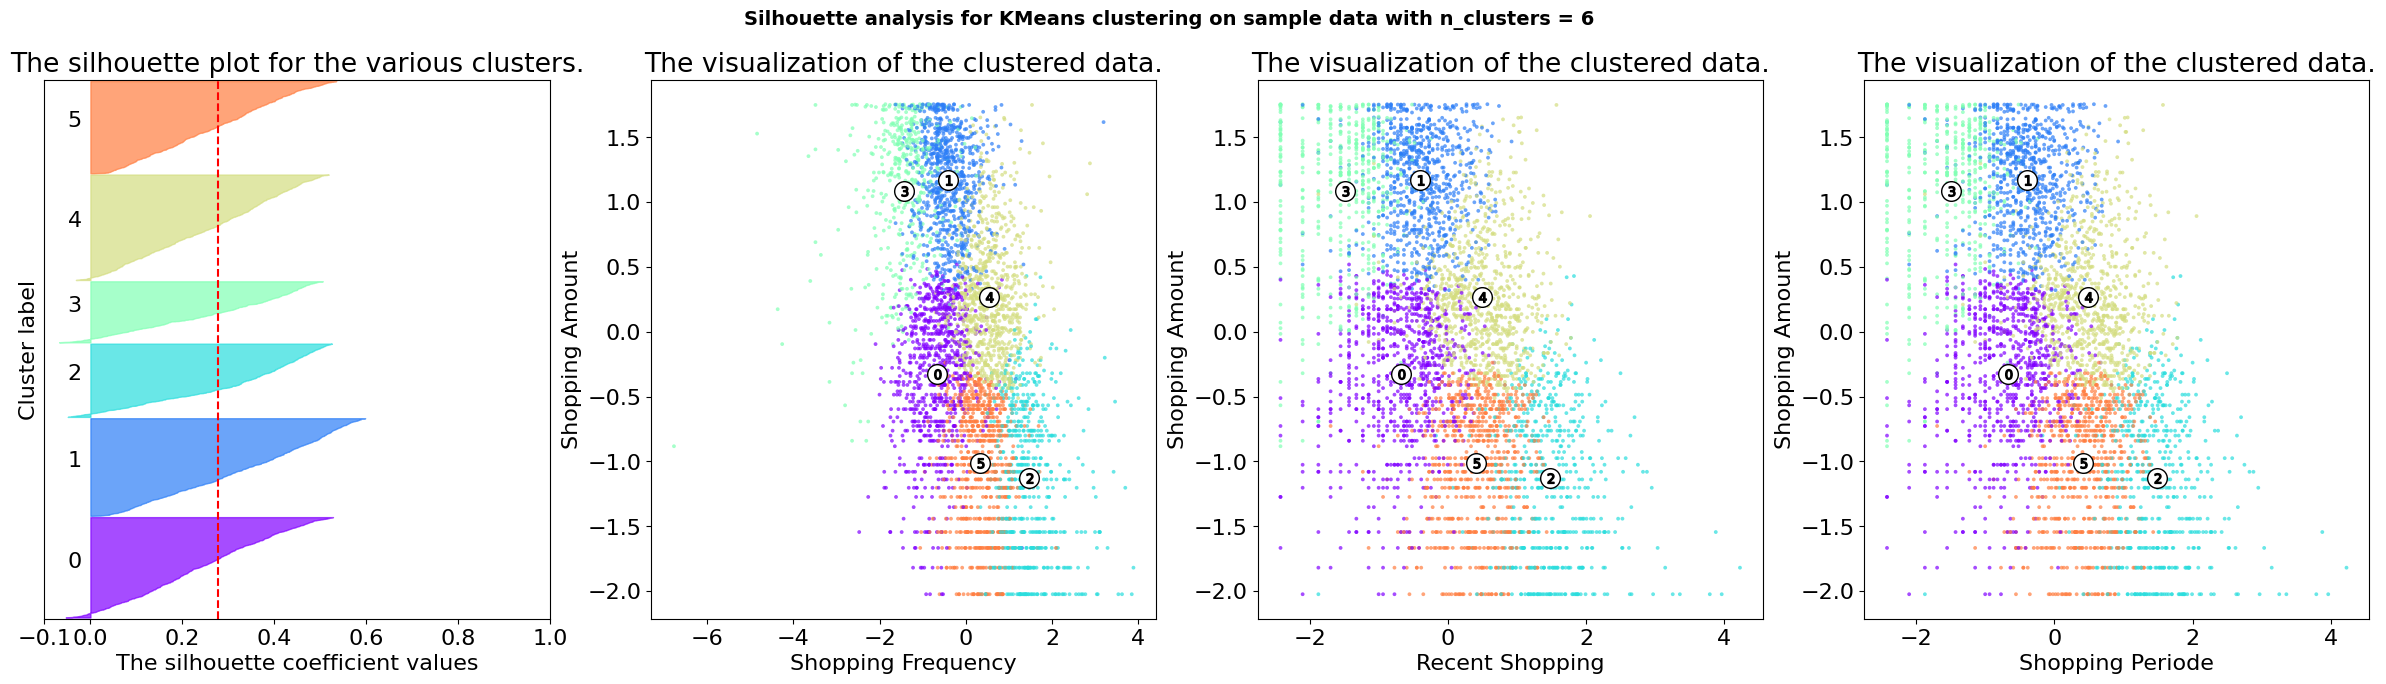

In [58]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(30, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_transform) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_transform)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_transform, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_transform, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_transform['Monetary'], rfm_transform['Recency'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 2], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[2], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Shopping Frequency")
    ax2.set_ylabel("Shopping Amount")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

        # 3nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax3.scatter(rfm_transform['Frequency'], rfm_transform['Recency'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("The visualization of the clustered data.")
    ax3.set_xlabel("Recent Shopping")
    ax3.set_ylabel("Shopping Amount")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


    # 4nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax4.scatter(rfm_transform['Frequency'], rfm_transform['Recency'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax4.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax4.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax4.set_title("The visualization of the clustered data.")
    ax4.set_xlabel("Shopping Periode")
    ax4.set_ylabel("Shopping Amount")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


plt.show()

In [59]:
n = 4

model = KMeans(n_clusters=n,init='k-means++',max_iter=300, n_init=10, random_state=0)

#fit the data
model_kmeans = model.fit(rfm_transform)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model_kmeans.labels_

centers = model_kmeans.cluster_centers_

#Append labels/clusters to scaled and original dataframe
rfm_cust['Cluster'] = labels
clusters_seg = pd.DataFrame(rfm_transform,columns=['Recency','Frequency','Monetary'])
clusters_seg['Cluster'] = labels+1

clusters = []

for i in range(0,n):
    clusters.append(rfm_cust[rfm_cust['Cluster']==i])

values = power.inverse_transform(scaler.inverse_transform(centers))

for i in range(0,n):
    print('-----CLUSTER {}-----'.format(i+1))
    print('Number of Customers: {}'.format(clusters[i].shape[0]))
    print('(Recency)Last Day Shopping: {:4.0f}'.format(values[i][0]))
    print('(Frec)Purchases Frequency : {:4.0f}'.format(values[i][1]))
    print('(Monetary)Total purchases: £{:6.2f}\n'.format(values[i][2]))

-----CLUSTER 1-----
Number of Customers: 962
(Recency)Last Day Shopping:   24
(Frec)Purchases Frequency :   21
(Monetary)Total purchases: £347.56

-----CLUSTER 2-----
Number of Customers: 1195
(Recency)Last Day Shopping:   78
(Frec)Purchases Frequency :   62
(Monetary)Total purchases: £1069.15

-----CLUSTER 3-----
Number of Customers: 1067
(Recency)Last Day Shopping:   10
(Frec)Purchases Frequency :  171
(Monetary)Total purchases: £2979.90

-----CLUSTER 4-----
Number of Customers: 1115
(Recency)Last Day Shopping:  199
(Frec)Purchases Frequency :   11
(Monetary)Total purchases: £217.98



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [60]:
rfm_transform['Cluster'] = model_kmeans.labels_
rfm_transform.head()

Recency  Frequency  Monetary  Cluster
CustomerID                                        
12346       1.617262  -2.420116  3.193082        1
12347      -1.818927   1.178407  1.377477        2
12348       0.300127  -0.219010  0.745038        1
12349      -0.691692   0.451547  0.728345        2
12350       1.567401  -0.677875 -0.592290        3

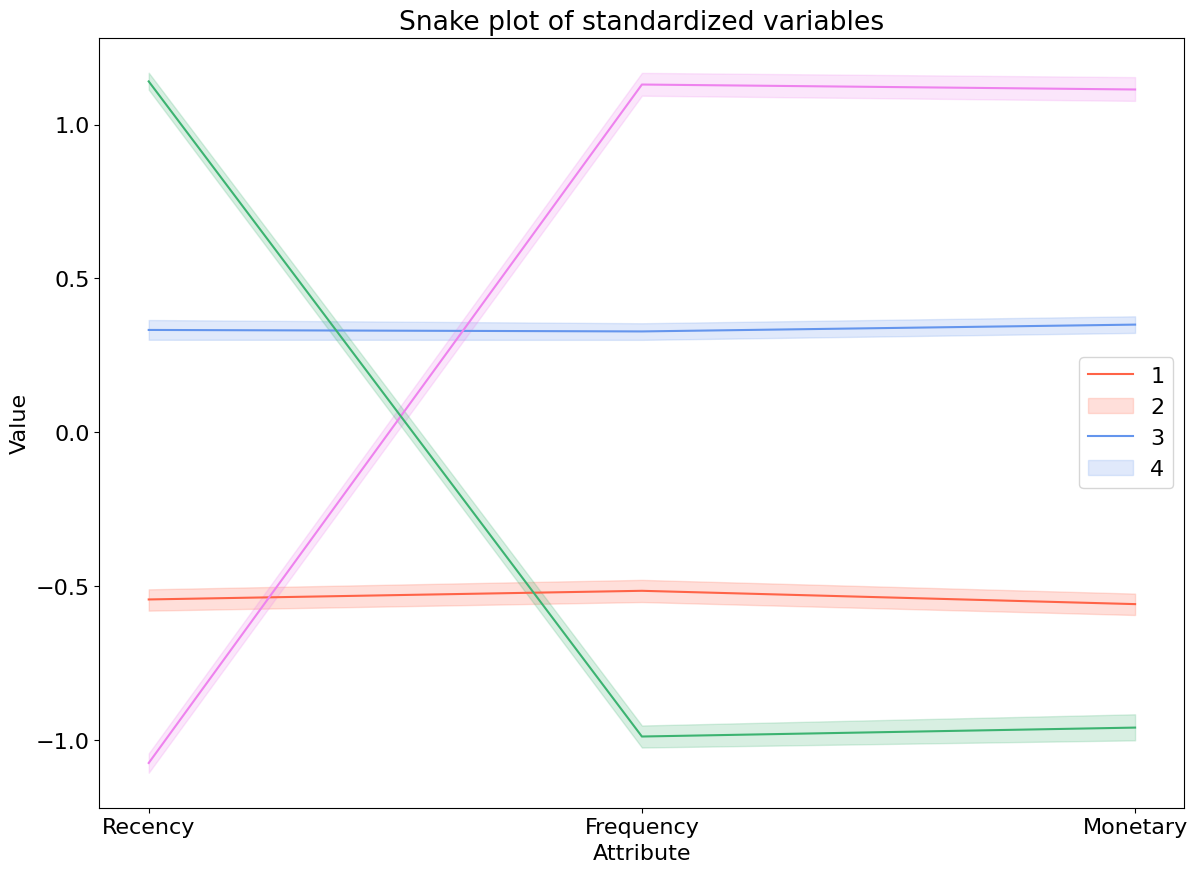

In [61]:
data_melt = pd.melt(rfm_transform.reset_index(), id_vars=['CustomerID','Cluster'], value_vars=['Recency','Frequency','Monetary'], var_name='Attribute', value_name='Value')
plt.figure(figsize=(14,10))
plt.title('Snake plot of standardized variables')
ax = sns.lineplot(x='Attribute', y='Value', hue='Cluster',palette=['tomato','cornflowerblue','violet','mediumseagreen'], data=data_melt, sort=False)
ax.legend(['1','2','3','4'])
plt.show()

In [66]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
print('Top 5 Country in Online Retail:')
df['Country'].value_counts()[:5]

Top 5 Country in Online Retail:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


United Kingdom    354345
Name: Country, dtype: int64

In [68]:
df = df[df['Country']=='United Kingdom']
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

  InvoiceMonth CohortMonth  IndexTime  
0   2010-12-01  2010-12-01          1  
1   2010-12-01  2010-12-01          1  
2   2010-12-01  2010-12-01          1  
3   2010-12-01  2010-12-01          1  
4   2010-12-01  2010-12-01          1

In [69]:
basket = df.groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
536365                          0.0                         0.0   
536366                          0.0                         0.0   
536367                          0.0                         0.0   
536368                          0.0                         0.0   
536369                          0.0                         0.0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
536365                             0.0                        0.0   
536366                             0.0                        0.0   
536367                             0.0                        0.0   
536368                             0.0                        0.0   
536369                             0.0                        0.0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
536365                                0.0                               0.0   
536366                                0.0                               0.0   
536367                                0.0                               0.0   
536368                                0.0                               0.0   
536369                                0.0                               0.0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
536365                                   0.0                            0.0   
536366                                   0.0                            0.0   
536367                                   0.0                            0.0   
536368                                   0.0                            0.0   
536369                                   0.0                            0.0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
536365                                       0.0                          0.0   
536366                                       0.0                          0.0   
536367                                       0.0                          0.0   
536368                                       0.0                          0.0   
536369                                       0.0                          0.0   

Description  ...  ZINC STAR T-LIGHT HOLDER  ZINC SWEETHEART SOAP DISH  \
InvoiceNo    ...                                                        
536365       ...                       0.0                        0.0   
536366       ...                       0.0                        0.0   
536367       ...                       0.0                        0.0   
536368       ...                       0.0                        0.0   
536369       ...                       0.0                        0.0   

Description  ZINC SWEETHEART WIRE LETTER RACK  ZINC T-LIGHT HOLDER STAR LARGE  \
InvoiceNo                                                                       
536365                                    0.0                             0.0   
536366                                    0.0                             0.0   
536367                                    0.0                             0.0   
536368                                    0.0                             0.0   
536369                                    0.0                             0.0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
536365                                   0.0                              0.0   
536366                                   0.0   

In [70]:
def encode_units(x):
  if x <= 0:
    return 0
  if x >= 1:
    return 1
basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', axis = 1, inplace = True)
basket_sets.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
536365                            0                           0   
536366                            0                           0   
536367                            0                           0   
536368                            0                           0   
536369                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
536365                               0                          0   
536366                               0                          0   
536367                               0                          0   
536368                               0                          0   
536369                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
536365                                  0                                 0   
536366                                  0                                 0   
536367                                  0                                 0   
536368                                  0                                 0   
536369                                  0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
536365                                     0                              0   
536366                                     0                              0   
536367                                     0                              0   
536368                                     0                              0   
536369                                     0                              0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
536365                                         0                            0   
536366                                         0                            0   
536367                                         0                            0   
536368                                         0                            0   
536369                                         0                            0   

Description  ...  ZINC STAR T-LIGHT HOLDER  ZINC SWEETHEART SOAP DISH  \
InvoiceNo    ...                                                        
536365       ...                         0                          0   
536366       ...                         0                          0   
536367       ...                         0                          0   
536368       ...                         0                          0   
536369       ...                         0                          0   

Description  ZINC SWEETHEART WIRE LETTER RACK  ZINC T-LIGHT HOLDER STAR LARGE  \
InvoiceNo                                                                       
536365                                      0                               0   
536366                                      0                               0   
536367                                      0                               0   
536368                                      0                               0   
536369                                      0                               0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
536365                                     0                                0   
536366                                     0   

In [71]:
frequent_itemsets = apriori(basket_sets, min_support = 0.02, use_colnames= True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values('support', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


antecedents                        consequents  \
12          (JUMBO BAG RED RETROSPOT)          (JUMBO BAG PINK POLKADOT)   
13          (JUMBO BAG PINK POLKADOT)          (JUMBO BAG RED RETROSPOT)   
27          (LUNCH BAG  BLACK SKULL.)          (LUNCH BAG RED RETROSPOT)   
26          (LUNCH BAG RED RETROSPOT)          (LUNCH BAG  BLACK SKULL.)   
6   (ROSES REGENCY TEACUP AND SAUCER)  (GREEN REGENCY TEACUP AND SAUCER)   
..                                ...                                ...   
45          (LUNCH BAG PINK POLKADOT)        (LUNCH BAG SPACEBOY DESIGN)   
32          (LUNCH BAG RED RETROSPOT)           (LUNCH BAG APPLE DESIGN)   
33           (LUNCH BAG APPLE DESIGN)          (LUNCH BAG RED RETROSPOT)   
46            (LUNCH BAG SUKI DESIGN)          (LUNCH BAG PINK POLKADOT)   
47          (LUNCH BAG PINK POLKADOT)            (LUNCH BAG SUKI DESIGN)   

    antecedent support  consequent support   support  confidence       lift  \
12            0.086912            0.048772  0.030392    0.349689   7.169917   
13            0.048772            0.086912  0.030392    0.623153   7.169917   
27            0.059823            0.067271  0.029071    0.485944   7.223641   
26            0.067271            0.059823  0.029071    0.432143   7.223641   
6             0.040723            0.036759  0.028590    0.702065  19.099148   
..                 ...                 ...       ...         ...        ...   
45            0.050934            0.052436  0.020061    0.393868   7.511463   
32            0.067271            0.044807  0.020001    0.297321   6.635529   
33            0.044807            0.067271  0.020001    0.446381   6.635529   
46            0.050213            0.050934  0.020001    0.398325   7.820423   
47            0.050934            0.050213  0.020001    0.392689   7.820423   

    leverage  conviction  zhangs_metric  
12  0.026153    1.462728       0.942438  
13  0.026153    2.422965       0.904650  
27  0.025046    1.814449       0.916387  
26  0.025046    1.655657       0.923704  
6   0.027093    3.233057       0.987871  
..       ...         ...            ...  
45  0.017391    1.563297       0.913393  
32  0.016987    1.359359       0.910550  
33  0.016987    1.684784       0.889136  
46  0.017444    1.577374       0.918237  
47  0.017444    1.563921       0.918935  

[76 rows x 10 columns]

In [72]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents  \
5                    (PINK REGENCY TEACUP AND SAUCER)   
71  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
72  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   

                          consequents  antecedent support  consequent support  \
5   (GREEN REGENCY TEACUP AND SAUCER)            0.029611            0.036759   
71  (GREEN REGENCY TEACUP AND SAUCER)            0.023004            0.036759   
72  (ROSES REGENCY TEACUP AND SAUCER)            0.024266            0.040723   

     support  confidence       lift  leverage  conviction  zhangs_metric  
5   0.024266    0.819473  22.293137  0.023177    5.335706       0.984289  
71  0.020482    0.890339  24.221015  0.019636    8.783841       0.981287  
72  0.020482    0.844059  20.726763  0.019494    6.151553       0.975423